# 机器学习纳米学位毕业项目 -- 猫狗大战
---

苗沛

2018.08.15

## 项目说明
---

使用深度学习方法识别一张图片是猫还是狗，这是一个二分类问题。1表示分类结果是狗，0表示分类结果是猫。

- 输入：一张彩色图片
- 输出：是猫还是狗

## 实验环境
---

项目使用Anaconda搭建环境。可是使用environment目录下的yml进行环境安装。

```shell
$ conda env create -f environment.yml
```

## 数据探索及预处理
---

从 [Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) 下载训练数据到`image目录` 并解压到当前目录。

数据集由训练数据和测试数据组成，训练数据包含猫和狗各12500张图片，测试数据包含12500张猫和狗的图片。

从训练集中提取图片可视化显示。

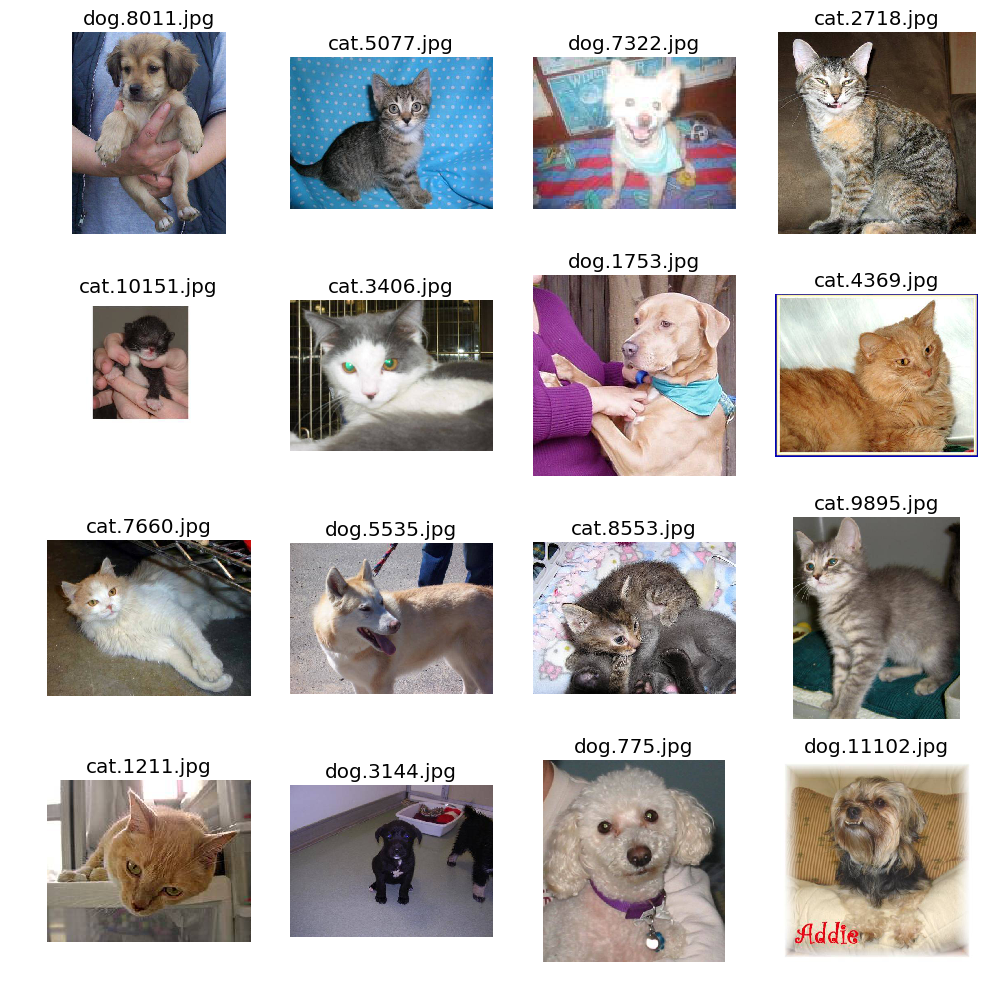

In [8]:
from keras.preprocessing.image import load_img
import random
plt.style.use('seaborn-white')

os.chdir("{}/image".format(os.getcwd())) 

namelist = os.listdir('train/')
plt.figure(figsize=(12, 12))
for i in range(0, 16):
    plt.subplot(4, 4, i+1)
    img = load_img("train/" + namelist[i])
    plt.title(namelist[i])
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

绘制训练集中图片的尺寸散点分布图。

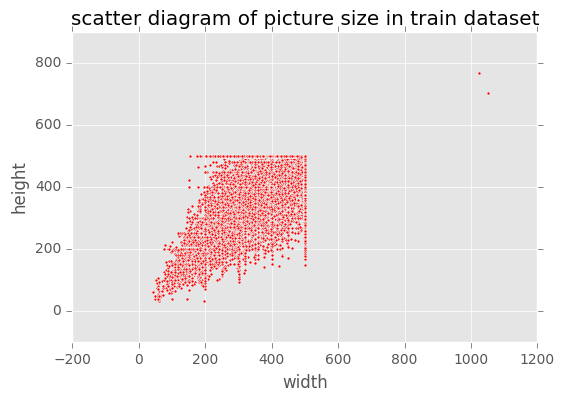

In [11]:
from keras.preprocessing.image import img_to_array, load_img
import os
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

targetnames = os.listdir('train/')
heights = []
widths = []
for name in targetnames[1:]:
    img = load_img('train/' + name)
    x = img_to_array(img)
    heights.append(x.shape[0])
    widths.append(x.shape[1])

x = np.array(widths)
y = np.array(heights)
area = np.pi * (35 * 0.05)**2  # dot's size

plt.scatter(x, y, s=area, c='red', alpha=1, marker = 'o')
plt.title('scatter diagram of picture size in train dataset')
plt.xlabel('width')
plt.ylabel('height')
plt.show()

获取训练集中高度或者宽度小于50的图片。

In [25]:
# explore the size of the pictures in train dataset

from keras.preprocessing.image import img_to_array, load_img
import os
import numpy as np
import matplotlib.pyplot as plt

# get the heights & widths of each picture into heights[], widths[]

targetnames = os.listdir('train/')
bad_picture = []
for name in targetnames[1:]:
    img = load_img('train/'+name)
    x = img_to_array(img)
    if x.shape[0] < 50 or x.shape[1] < 50:
        bad_picture.append(name) 
print(bad_picture)

['dog.4367.jpg', 'dog.11248.jpg', 'dog.9246.jpg', 'dog.10747.jpg', 'cat.10392.jpg', 'dog.10733.jpg', 'cat.2433.jpg', 'cat.9171.jpg', 'dog.1324.jpg', 'dog.7011.jpg', 'dog.11686.jpg', 'cat.6402.jpg', 'cat.6614.jpg', 'cat.5527.jpg', 'cat.4821.jpg', 'cat.5534.jpg', 'dog.9705.jpg', 'dog.2652.jpg']


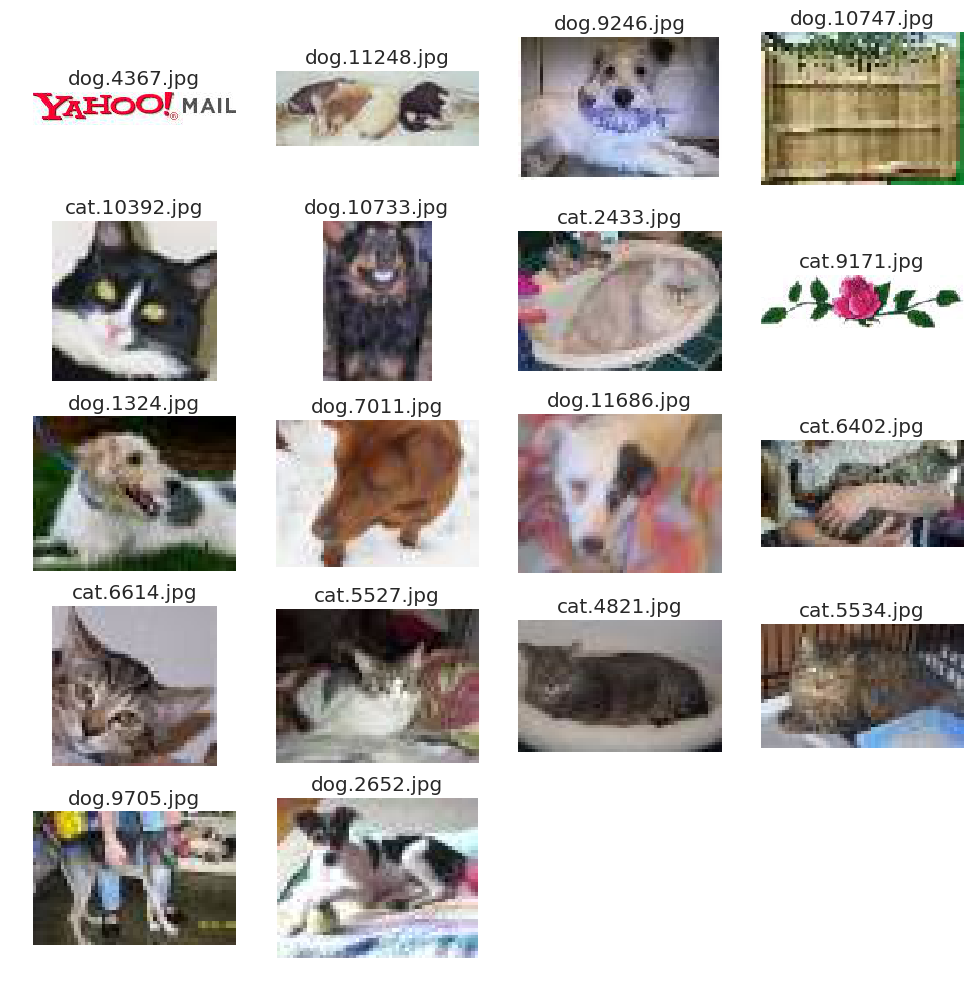

In [36]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from math import ceil
plt.style.use('seaborn-white')

plt.figure(figsize=(12, 12))
for i in range(0, len(bad_picture)):
    plt.subplot(ceil(len(bad_picture) / 4), 4, i+1)
    img = load_img('train/'+ bad_picture[i])
    x = img_to_array(img)
    plt.title(bad_picture[i])
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

绘制测试集中图片的尺寸散点分布图

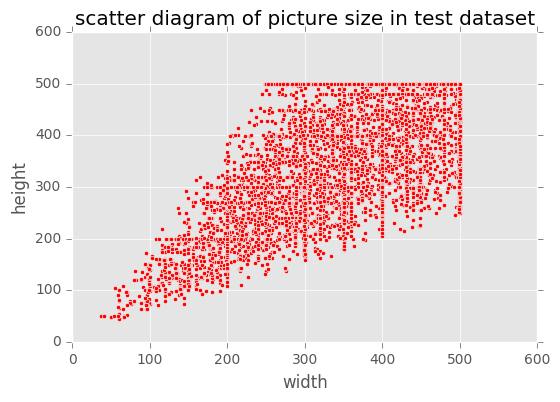

In [13]:
from keras.preprocessing.image import img_to_array, load_img
import os
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

targetnames = os.listdir('test/')
heights = []
widths = []
for name in targetnames[1:]:
    img = load_img('test/'+name)
    x = img_to_array(img)
    heights.append(x.shape[0])
    widths.append(x.shape[1])

x = np.array(widths)
y = np.array(heights)
area = np.pi * (35 * 0.05)**2  # dot's size

plt.scatter(x, y, s=area, c='r', alpha=1, marker = 'o')
plt.title('scatter diagram of picture size in test dataset')
plt.xlabel('width')
plt.ylabel('height')
plt.show()

数据集中的文件名是以type.num.jpg方式命名的，比如cat.0.jpg。使用 Keras 的 ImageDataGenerator 需要将不同种类的图片分在不同的文件夹中。对数据集进行预处理参考的是[杨培文的Blog](http://www.zhiding.cn/techwalker/documents/J9UpWRDfVYHE5WsOEHbyx4eM8fBcpHYEW_b72QCUihQ)创建符号链接(symbol link)的方法，这样的好处是不用复制一遍图片，占用不必要的空间。

In [1]:
import os
import shutil

train_filenames = os.listdir('train')
train_cat = filter(lambda x:x[:3] == 'cat', train_filenames)
train_dog = filter(lambda x:x[:3] == 'dog', train_filenames)

def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

rmrf_mkdir('img_train')
os.mkdir('img_train/cat')
os.mkdir('img_train/dog')

rmrf_mkdir('img_test')
os.symlink('../test/', 'img_test/test')

for filename in train_cat:
    os.symlink('../../train/'+filename, 'img_train/cat/'+filename)

for filename in train_dog:
    os.symlink('../../train/'+filename, 'img_train/dog/'+filename)

图像文件分类后的路径如下：

``` python
image/
├── test [12500 images]
├── img_test
│   ├── test -> ../test/
├── train [25000 images]
├── img_train
│   ├── cat [12500 images]
│   └── dog [12500 images]
``` 

可视化数据集：

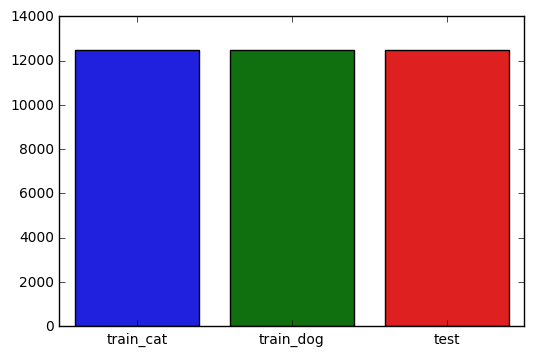

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

x = ['train_cat', 'train_dog', 'test']
y = [len(os.listdir('img_train/cat')), len(os.listdir('img_train/dog')), len(os.listdir('test'))]
ax = sns.barplot(x=x, y=y)

In [3]:
s_count = """image数据集中，猫的数量：{}，狗的数量：{}，测试集图片数量：{}""".format(len(os.listdir('img_train/cat')), len(os.listdir('img_train/dog')),len(os.listdir('test')))
s_count

'image数据集中，猫的数量：12500，狗的数量：12500，测试集图片数量：12500'

## 问题分析及模型选择
---

在给定一张图片，系统需要预测出图像属于预先定义类别中的哪一类。在计算机视觉领域，目前解决这类问题的核心技术框架是深度学习（Deep Learning），特别地，针对图像类型的数据，是深度学习中的卷积神经网络（Convolutional Neural Networks, ConvNets）架构。总的来说，卷积神经网络是一种特殊的神经网络结构，即通过卷积操作可以实现对图像特征的自动学习，选取那些有用的视觉特征以最大化图像分类的准确率。

<img src="source/cat_dog_classify.gif"/>

上图给出了一个简单的猫狗识别的卷积神经网络结构，在最底下（同时也是最大的）的点块表示的是网络的输入层（Input Layer），通常这一层作用是读入图像作为网络的数据输入。在最上面的点块是网络的输出层（Output Layer），其作用是预测并输出读入图像的类别，在这里由于只需要区分猫和狗，因此输出层只有2个神经计算单元。而位于输入和输出层的，都称之为隐含层（Hidden Layer），图中有3个隐含层，图像分类的隐含层都是由卷积操作完成的，因此这样的隐含层也成为卷积层（Convolutional Layer）。因此，输入层、卷积层、输出层的结构及其对应的参数就构成了一个典型的卷积神经网络。当然，在实际中使用的卷积神经网络要比这个示例的结构更加复杂，自2012年的ImageNet比赛起，几乎每一年都会有新的网络结构诞生，已经被大家认可的常见网络有AlexNet, VGG-Net, GoogLeNet, Inception V2-V4, ResNet等等。这些卷积神经网络都是在ImageNet数据集上表现非常优异的神经网络，具体准确率和模型大小如下图所示。

<img src="source/nnarch1-1.png"/>

<img src="source/imagenet_info.png">

卷积神经网络中卷积层和池化层主要是对图片的几何特征进行抽取，比如浅层的卷积池化层可以抽取出一些直线，角点等简单的抽象信息，深层的卷积池化层可以抽取人脸等复杂的抽象信息，最后的全连接层才是对图片分类的关键处理。因此可以利用已经训练好的卷积神经网络提取图片中复杂的几何特征，即将原始图片用已经训练好的卷积神经网络处理之后的输出，作为新的输入，然后加上自己的全连接层，去进行分类。在模型训练的过程中，只改变新加的全连接层的权重。

由于每一种神经网络提取的特征都不一样，因此本项目将多个神经网络处理的结果拼接，作为最后一层全连接层的输入，这样做可以有效地降低方差。

本项目迁移学习部分使用Keras实现，而Keras中可以导入的模型有Xception，VGG16，VGG19，ResNet50，InceptionV3，InceptionResNet -V2，MobileNet. 综合考虑模型的分类准确率和大小，选用迁移学习的基础模型为ResNet50，InceptionV3和Xception。

## 生成迁移学习特征向量
---

Xception，InceptionV3和ResNet50这三个模型对于输入数据都有各自的默认值，比如在输入图片大小维度上，Xception和InceptionV3默认输入图片大小是299*299，ResNet50默认输入图片大小是224*224；在输入数值维度上，Xception和InceptionV3默认输入数值在(-1, 1)范围内。当要输入与默认图片大小不同的图片时，只需传入当前图片大小即可。ResNet50需要对图片进行中心化处理，由于载入的ResNet50模型是在ImageNet数据上训练出来的，所以在预处理中每个像素点都要减去ImageNet均值。当要输入与默认图片大小不同的图片时，只需传入当前图片大小即可。当输入数值不符合默认要求时，使用每个模型的预处理函数`preprocess_input`即可将输入图片处理成该模型的标准输入。

常见的卷积神经网络结构在前面的若干层都是卷积池化层及其各种变种，后面几层都是全连接层，这些全连接层之前的网络层被称为瓶颈层 (bottleneck). 将新的图片通过训练好的卷积神经网络直到瓶颈层的过程可以看做是对图像进行特征提取的过程。一般情况下，为了减少内存的消耗， 加快计算的过程，再将瓶颈层的结果输入全连接层之前，做一次全局平均 池化，比如ResNet50瓶颈层输出结果是7*7*2048，如果直接输入到全连接层，参数会非常多，所以进行一次全局平均池化，将输出矩阵调整为 1*1*2048，这么做还有一个好处，那就是可以降低过拟合的程度。

在Keras中载入模型并进行全局平均池化，只需要在载入模型的时候，设置include_top=False, pooling='avg'. 每个模型都将图片处理成一个 1*2048的行向量，将这三个行向量进行拼接，得到一个1*6144的行向量， 作为数据预处理的结果。

In [ ]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

import h5py

def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False, pooling='avg')
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
    
    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory("img_train", image_size, shuffle=False, 
                                              batch_size=16)
    test_generator = gen.flow_from_directory("img_test", image_size, shuffle=False, 
                                             batch_size=16, class_mode=None)

    train = model.predict_generator(train_generator, train_generator.nb_sample)
    test = model.predict_generator(test_generator, test_generator.nb_sample)

    with h5py.File("gap_%s.h5"%MODEL.__name__) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

In [ ]:
#write_gap(ResNet50, (224, 224))

In [ ]:
#write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)

In [ ]:
#write_gap(Xception, (299, 299), xception.preprocess_input)

## 载入特征向量
---

经过上面的代码以后，我们获得了三个特征向量文件，分别是：

- gap_ResNet50.h5
- gap_InceptionV3.h5
- gap_Xception.h5

这里需要载入这些特征向量，并且将它们合成一条特征向量，然后记得把 X 和 y 打乱，不然之后设置validation_split的时候会出问题。这里设置了 numpy 的随机数种子为2018。

In [ ]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2018)

X_train = []
X_test = []

for filename in ["gap_ResNet50.h5", "gap_Xception.h5", "gap_InceptionV3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

## 构建模型
---

载入预处理的数据之后，先进行一次概率为0.5的dropout，然后直接连接输出层，激活函数为Sigmoid，优化器为Adadelta，输出一个零维张量，表示某张图片中有狗的概率。

In [ ]:
from keras.models import *
from keras.layers import *

input_tensor = Input(X_train.shape[1:])
print(input_tensor)
x = input_tensor
print(x)
x = Dropout(0.5)(x)
print(x)
x = Dense(1, activation='sigmoid')(x)
print(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

对模型进行可视化：

进入model_graphviz目录执行make，生成model.png

整个迁移学习的神经网格结构如下所示。

<img src="source/model.png">

In [20]:
# from graphviz import Digraph

# dot = Digraph()
# dot.attr('node', shape='box')
# dot.node('i', 'Image')
# dot.node('a', 'ResNet50 {input: output:} | {(224, 224, 3) (2048)}')
# dot.node('b', 'InceptionV3 {input: output:} | {(229, 229, 3) (2048)}')
# dot.node('c', 'Xception {input: output:} | {(229, 229, 3) (2048)}')
# dot.node('M', 'Merge {input: output:} | {(3, 2048)|(6144)}')
# dot.node('d', 'Dropout Rate: 0.5')
# dot.node('O', 'Output {input: output:} | {(6144) (1)}')

# dot.edges(['ia', 'ib', 'ic'])
# dot.edges(['aM', 'bM', 'cM'])
# dot.edges(['Md'])
# dot.edges(['dO'])
# dot.render('source/test_model.gv', view=True) 

'source/test_model.gv.pdf'

## 训练模型
---

模型构件好了以后，我们就可以进行训练了，这里我们设置验证集大小为 20% ，也就是说训练集是20000张图，验证集是5000张图。

In [ ]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot, plot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
#hist = model.fit(X_train, y_train, batch_size=128, nb_epoch=8, validation_split=0.2)

In [ ]:
# 模型概括
model.summary()

In [ ]:
from keras.callbacks import *

model_history = model.fit(X_train, 
                    y_train,
                    batch_size=128,
                    nb_epoch=8,
                    verbose=1,
                    validation_split=0.2,
                    callbacks = [TensorBoard(log_dir='./Graph')])

model.save('model.h5')

In [ ]:
# tensorboard --logdir='你存event的目录'

训练过中的loss和accuracy如下：

<img src="source/TensorBoard_loss.png">

<img src="source/TensorBoard_acc.png">

In [ ]:
# plt.plot(hist.history['val_loss'])
# #plt.xlabel('time')
# #plt.ylabel('val_loss')
# plt.title('Training and validation loss')
# plt.show()

# plt.plot(hist.history['val_acc'])
# #plt.xlabel('times')
# #plt.ylabel('val_acc')
# plt.title('Training and validation accuracy')
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# # 画图
# def plot_training(history):
#     acc = history.history['acc']
#     val_acc = history.history['val_acc']
#     epochs = range(len(acc))
#     plt.plot(epochs, acc, 'r.')
#     plt.plot(epochs, val_acc, 'r')
#     plt.title('Training and validation accuracy')
#     plt.figure()

#     loss = history.history['loss']
#     val_loss = history.history['val_loss']   
#     plt.plot(epochs, loss, 'r.')
#     plt.plot(epochs, val_loss, 'r-')
#     plt.title('Training and validation loss')
#     plt.show()

# # 训练的acc_loss图
# plot_training(hist)

## 预测测试集
---

使用训练好的模型中对处理过的测试集数据进行分类，得到每张图片中有狗的概率。在提交的kaggle之前，先使用`numpy.clip()`函数做一个截断处理，将所有图片的概率值限制在$[0.005, 0.995]$之间，这样可以稍微降低loss。

kaggle 官方的评估标准是 LogLoss，下面的表达式就是二分类问题的 LogLoss 定义。

$$\textrm{LogLoss} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]$$

$|log(1)|=0.000$

$|log(0.995)|=0.0050$

$lim_{x\to 0}|log(x)|=\infty$

$|log(0.005)|=5.2983$

不过由于kaggle本身就做了一次截断，限制了最小值为$1e-15$，又$|log(1e−15)|=34.5388$。 所以如果把预测正确的概率从1截断到$0.995$，单张图片的loss最多增加$0.0050$，但是如果把预测错误的概率从$1e-15$截断到$0.005$，那么会极大地降低loss。

测试集图片id的顺序为：

In [41]:
%ls test | head -n 10

1.jpg
10.jpg
100.jpg
1000.jpg
10000.jpg
10001.jpg
10002.jpg
10003.jpg
10004.jpg
10005.jpg


由于kaggle是根据id来确定每张图片的类别的，因此我们需要对每个文件名进行处理，然后赋值到 df 里，最后导出为 csv 文件。

In [ ]:
import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

image_size = (224, 224)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("img_test", image_size, shuffle=False, 
                                         batch_size=16, class_mode=None)

y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred.csv', index=None)
df.head(10)

将测试集的处理结果提交到kaggle上，loss为0.04150，和验证集的loss近似。

<img src="source/cat_vs_dog_kaggle_score.png">

## 结果分析
---

单个ResNet50模型5次迭代训练结果：

- 训练集loss：0.0755，验证集loss：0.0419。

使用Xception，InceptionV3和ResNet50这三个模型进行迁移学习5次迭代训练结果：

- 训练集loss：0.0755，验证集loss：0.0419。

原始的Xception有126层，原始的InceptionV3有159层，原始的ResNet50有168层，更多的层数，不同的卷积核各种各样的的组合，可以更好的抽取图片中的泛化特征，这样既可以提高分类的准确率，又可以降低模型的过拟合风险，所以现在在各种比赛中斩头露角的神经网络层数都非常的多，深度很深，这也是类似的神经网络被称为深度学习的一个主要原因。

Xception，InceptionV3和ResNet50这三个模型进行组合迁移学习，效果比先单个神经网络模型效果好。这里利用了bagging的思想，通过多个模型处理数据并进行组合，可以有效降低模型的方差，减少过拟合程度，提高分类准确率。

## 小结
---

深度学习毫无疑问是处理图像问题最佳的机器模型，近年来各大赛的前几名均是通过深度学习获取了前几名的好成绩。但是相比于传统的机器学习模型，深度学习需要更多的数据，更强大的算力和资源。因为有些情况，在训练迁移学习模型使用的是自己的Mac，足足跑了三天训练完，泪崩。建议在使用的时候用云计算平台去训练。

kaggle上猫狗大战前几名的loss达到了0.0330，相比于本文中的0.0447，绝对值减少了0.0117，相对值减少了26.17%，说明还是有较大的改进空间。本文只是使用的Xception，InceptionV3和ResNet50这三个模型进行了提取特征向量，然后将特征向量直接拼接，忽略了特征之间的位置关系。除了这三个模型，还可以增加更多新的模型，或者使用stacking的方法进行模型融合，进一步降低方差，提高分类的准确率。还可以从原始样本上入手，有些图片的分类概率正确，但是不够确定，可以先做一部分处理，然后让模型更加确定。

相比Keras，TensorFlow真的真的太麻烦了，但是Google为什么要把TensorFlow做的这么麻烦呢？个人认为是为了运行的高效率和极大的灵活性做出了让步。TensorFlow是经过工业界实际产品考验过的框架，生态及其丰富，想实现一个功能，有多种写法，学起来有一种C++的感觉。。。Keras更像是为了快速出活的框架，如果想做一些改动十分的麻烦，Keras的默认backend就是TensorFlow，所以Keras的执行效率是比TensorFlow慢很多的。TensorFlow1.4里面已经把tf.contrib.keras更改为核心模块tf.keras，所以TensorFlow以后用起来应该也会方便很多。最后还想说的是PyTorch，好多人都推荐，说不仅仅有TensorFlow的高效率，而且很pythonic，可以在任意层和numpy数组进行转化，大家有时间可以了解了解~

In [ ]:
from IPython.display import display

data = pd.read_csv("pred.csv")
display(data.head(n=10))

In [ ]:
train_generator.class_indices

In [ ]:
gen = ImageDataGenerator()
train_generator = gen.flow_from_directory("img_train", (224, 224), shuffle=False, batch_size=16)

print(train_generator.class_indices)